# Illustration of Slow Feature Analysis: sinusoidal modulation & FFT

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from importlib import reload
from src import examples
from src import sfa, n_pca_selector
from importlib import reload

(1048576,)


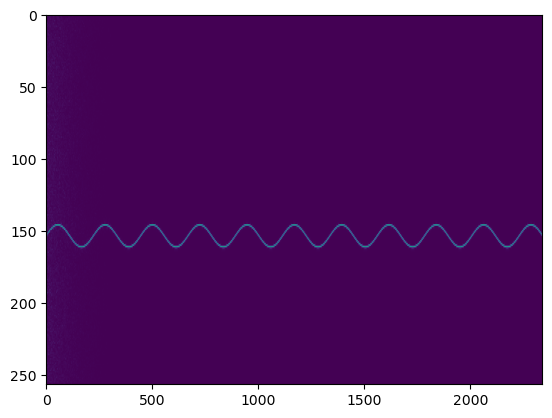

In [45]:

reload(sfa)
reload(examples)

df = examples.sinus_signal_fft(512**2 * 4,nperseg=256*2)
dfS = df.drop(["true", "noise"], axis=1)
plt.imshow(dfS.T, aspect="auto")
plt.show()


(2340, 213)


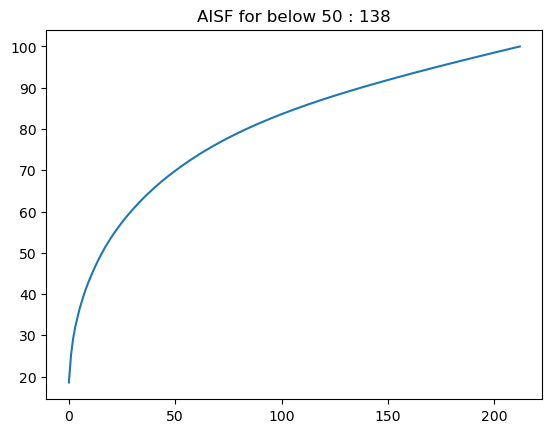

In [46]:

from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.preprocessing import SplineTransformer

# faire un objet pour PCA singlar au dessus de 1
reload(n_pca_selector)
reload(sfa)
n_lags = 2
poly_order = 3
pre = StandardScaler()
pre2 = StandardScaler()
# expansion = SplineTransformer(degree=poly_order, n_knots=4)
expansion = FunctionTransformer(lambda x: x)
# expansion = Nystroem(n_components=200)
# whiten = sfa.PCA_whiten_kaiser(singular_threshold=1e-0)  # 1 - (1e-14)
whiten = sfa.PCA_whiten_enthropy(threshold=0.85)
# whiten = n_pca_selector.PCAWithSignflipPA(
#     whiten=True, thresholding="pairwise", plotting=True, alpha=95
# )

center = StandardScaler(with_std=False)
diff = FunctionTransformer(sfa.differentiate)
lags = FunctionTransformer(sfa.make_lags, kw_args={"n_lags": n_lags})
laststep = sfa.PCA_whiten_kaiser(singular_threshold=1e-14)  # PCA()

pipe = Pipeline(
    [
        ("lag", lags),
        # ("pre", pre),
        ("expension", expansion),
        ("pre2", pre2),
        ("whiten", whiten),
        # ("pre2", pre2),
        ("diff", diff),
        ("centering", center),
        ("last", laststep),
    ]
)
pipe.fit(dfS)
names = [l[0] for l in pipe.steps]
index_whiten = [l[0] for l in pipe.steps].index("whiten")
xt = pipe[0 : (index_whiten + 1)].transform(dfS)
print(xt.shape)
xt = pipe[-1:].transform(xt)

ISSF = ((1 / pipe[-1].singular_values_) / (1 / pipe[-1].singular_values_).sum())[::-1]
AISF = ISSF.cumsum() / ISSF.sum() * 100
plt.plot(AISF)
nb = np.sum(AISF < 90)
plt.title(f"AISF for below 50 : {nb}")
plt.show()


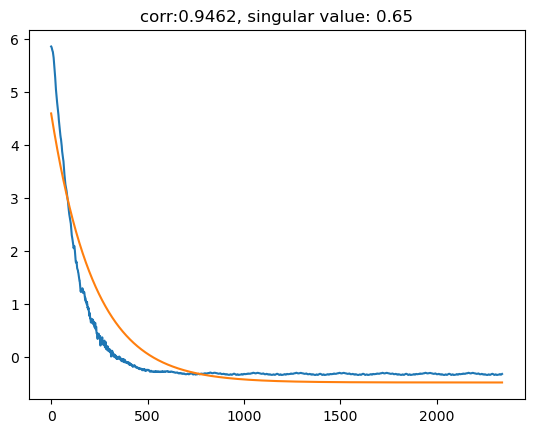

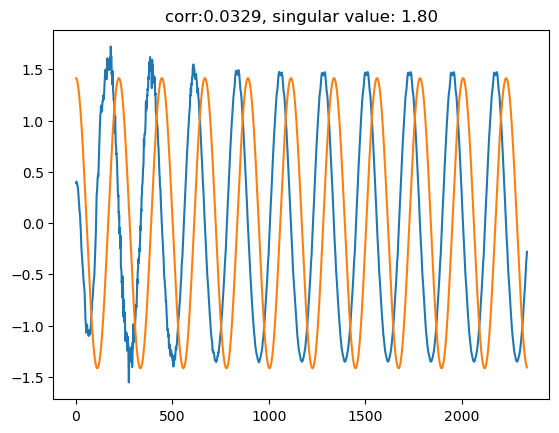

In [47]:
i_min = -1
true = df["noise"]
estimande = xt[:, i_min]
delta_value = pipe[-1].singular_values_[i_min]
corr = np.corrcoef(true, estimande)[0, 1]
plt.plot(examples.rescale(estimande) * np.sign(corr), label="estimande")
plt.title(f"corr:{corr:.4f}, singular value: {delta_value:.2f}")
plt.plot(examples.rescale(true), label="true")
plt.show()

i_min = -2
true = df["true"]
estimande = xt[:, i_min]
delta_value = pipe[-1].singular_values_[i_min]
corr = np.corrcoef(true, estimande)[0, 1]
plt.plot(examples.rescale(estimande) * np.sign(corr), label="estimande")
plt.title(f"corr:{corr:.4f}, singular value: {delta_value:.2f}")
plt.plot(examples.rescale(true), label="true")
plt.show()


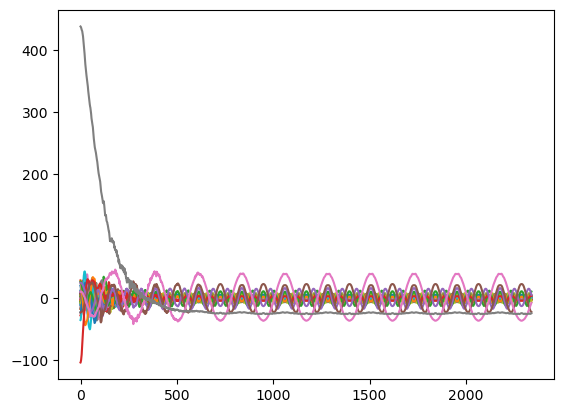

In [48]:


plt.plot(xt[:, -nb:])
plt.show()
